# Normalizing full-length gene sequencing data¶

## Opening the census¶

In [15]:
import cellxgene_census
import scanpy as sc
import numpy as np
from scipy.sparse import csr_matrix

In [16]:
census = cellxgene_census.open_soma()

The "stable" release is currently 2023-05-15. Specify 'census_version="2023-05-15"' in future calls to open_soma() to ensure data consistency.


## Fetching full-length example sequencing data (Smart-Seq)

In [17]:
liver_dataset = (
    census["census_info"]["datasets"]
    .read(
        value_filter="dataset_title == 'Liver - A single-cell transcriptomic atlas characterizes ageing tissues in the mouse - Smart-seq2'"
    )
    .concat()
    .to_pandas()
)

In [19]:
liver_dataset

,soma_joinid,collection_id,collection_name,collection_doi,dataset_id,dataset_title,dataset_h5ad_path,dataset_total_cell_count
0,494,0b9d8a04-bb9d-44da-aa27-705bb65b54eb,Tabula Muris Senis,10.1038/s41586-020-2496-1,4546e757-34d0-4d17-be06-538318925fcd,Liver - A single-cell transcriptomic atlas cha...,4546e757-34d0-4d17-be06-538318925fcd.h5ad,2859


In [20]:
liver_dataset_id = "4546e757-34d0-4d17-be06-538318925fcd"

In [21]:
liver_adata = cellxgene_census.get_anndata(
    census, organism="Mus musculus", obs_value_filter=f"dataset_id=='{liver_dataset_id}'"
)

In [22]:
liver_adata

AnnData object with n_obs × n_vars = 2859 × 52392
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [23]:
liver_adata.obs["assay"].value_counts()

Smart-seq2    2859
Name: assay, dtype: int64

In [24]:
census.close()

## Normalizing expression to account for gene length

In [25]:
liver_adata.n_vars

52392

In [26]:
liver_dataset_id = liver_dataset["soma_joinid"][0]

In [27]:
liver_dataset_id

494

In [28]:
presence_matrix = cellxgene_census.get_presence_matrix(census, "Mus musculus", "RNA")

In [30]:
presence_matrix = presence_matrix[liver_dataset_id, :]

In [32]:
gene_presence = presence_matrix.nonzero()[1]

In [45]:
presence_matrix

<1x52392 sparse matrix of type '<class 'numpy.uint8'>'
	with 17992 stored elements in Compressed Sparse Row format>

In [34]:
liver_adata = liver_adata[:, gene_presence].copy()

In [36]:
liver_adata

AnnData object with n_obs × n_vars = 2859 × 17992
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [37]:
liver_adata.n_vars

17992

In [46]:
liver_adata.X[:5, :5].toarray()

array([[2170.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.],
       [   0.,  639.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,   84.,    0.]], dtype=float32)

In [47]:
gene_lengths = liver_adata.var[["feature_length"]].to_numpy()

In [48]:
gene_lengths

array([[3583],
       [ 998],
       [ 619],
       ...,
       [  90],
       [  97],
       [  71]])

In [49]:
liver_adata.X = csr_matrix((liver_adata.X.T / gene_lengths).T)

In [51]:
liver_adata

AnnData object with n_obs × n_vars = 2859 × 17992
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [50]:
liver_adata.X[:5, :5].toarray()

array([[0.60563773, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.64028056, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.0443038 , 0.        ]])

## Validation through clustering exploration

In [52]:
sc.pp.filter_cells(liver_adata, min_genes=500)

In [53]:
sc.pp.filter_genes(liver_adata, min_cells=5)

In [54]:
sc.pp.normalize_total(liver_adata, target_sum=1e4)

In [55]:
sc.pp.log1p(liver_adata)

In [56]:
sc.pp.highly_variable_genes(liver_adata, n_top_genes=1000)

In [57]:
liver_adata = liver_adata[:, liver_adata.var.highly_variable].copy()

In [58]:
liver_adata

AnnData object with n_obs × n_vars = 2824 × 1000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'n_genes'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [59]:
sc.pp.scale(liver_adata, max_value=10)

In [60]:
sc.tl.pca(liver_adata)

In [61]:
sc.pp.neighbors(liver_adata)

/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/

In [62]:
sc.tl.umap(liver_adata)

/Users/tomoya/miniconda3/envs/py3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


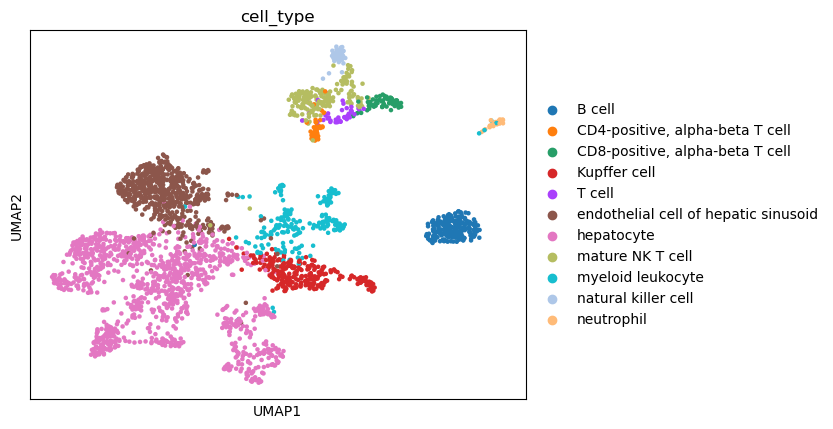

In [63]:
sc.pl.umap(liver_adata, color="cell_type")